EDA, Exploratory Data Analysis
===
latitude/logitude are given by unknown consersion. Suppose that this conversion formula still kept the original infomation, how could we extract their usefule information in prediction? As well-known knowledge, house price is dependent on the region where their locate; this is why we have to consider lat/lon infomation seriously.
1. nan conversion
2. target, $\mathbf{y\Rightarrow\log(1+y)}$ (`np.log1p`), for normalize fitting; later, back by $\mathbf{y_p \Rightarrow \exp(y_p)-1}$ (`np.expm1`)
- latitude/longitude conversion, a°). knn means, b°). dbscans, then one-hot converstion
  ```Lasso, 0.7012 ➡︎ 0.6893```, the last one can not assign a fixed value to fix the data.
- different models, xgb, lgb, ...; here we try the `lightgbm`;
- stack model, blend moder, ...; install `mlxtend` by pip.


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm,tqdm_notebook
import folium

import seaborn as sns
%matplotlib inline

In [3]:
train_df = pd.read_csv('../dataset/0514/train.csv')
test_df = pd.read_csv('../dataset/0514/test.csv')

In [4]:
print ("Train: ",train_df.shape[0],"sales, and ",train_df.shape[1],"features")
print ("Test:  ",test_df.shape[0],"sales, and ",test_df.shape[1],"features")

Train:  60000 sales, and  235 features
Test:   10000 sales, and  234 features


In [5]:
train_df.shape

(60000, 235)

In [6]:
train_df['total_price'].head()

0    6.476038e+05
1    3.321452e+06
2    9.570885e+06
3    1.421501e+07
4    7.627120e+05
Name: total_price, dtype: float64

In [7]:
train_df.columns.values

array(['building_id', 'building_material', 'city', 'txn_dt',
       'total_floor', 'building_type', 'building_use',
       'building_complete_dt', 'parking_way', 'parking_area',
       'parking_price', 'txn_floor', 'land_area', 'building_area', 'town',
       'lat', 'lon', 'village_income_median', 'town_population',
       'town_area', 'town_population_density', 'doc_rate', 'master_rate',
       'bachelor_rate', 'jobschool_rate', 'highschool_rate',
       'junior_rate', 'elementary_rate', 'born_rate', 'death_rate',
       'marriage_rate', 'divorce_rate', 'village', 'N_50', 'N_500',
       'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_index_50',
       'I_100', 'I_250', 'I_500', 'I_index_500', 'I_1000', 'I_index_1000',
       'I_5000', 'I_index_5000', 'I_10000', 'I_index_10000', 'I_MIN',
       'II_10', 'II_50', 'II_index_50', 'II_100', 'II_250', 'II_500',
       'II_index_500', 'II_1000', 'II_index_1000', 'II_5000',
       'II_index_5000', 'II_10000', 'II_index_10000', 'II_MIN', 'I

In [8]:
train_df['total_price'].describe()

count    6.000000e+04
mean     1.293727e+07
std      5.522463e+07
min      2.261495e+05
25%      2.433114e+06
50%      5.240482e+06
75%      1.123932e+07
max      5.088279e+09
Name: total_price, dtype: float64

ToDo List

· outliers  
· 

Data
---
1. Quantitative 定性
   - time-state: 'txn_dt', 'building_complete_dt'
   - non-time,
           'parking_price','building_area','village_income_median','town_population','town_area',
           'town_population_density','I_Min','II_MIN','III_MIN','IV_MIN','V_MIN','VI_MIN',
           'VII_MIN','VIII_MIN','IX_MIN','X_MIN','XI_MIN','XII_MIN','XIII_MIN','XIV_MIN',
   - location: 'lon','lat'
- Qualitative 定量
  - building_material(9),city(11),total_floor(29),building_type(5),building_use(10),parking_way,
    parking_area, txn_floor,'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate',
       'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate',
       'death_rate', 'marriage_rate', 'divorce_rate'
  - village(2899)     

In [9]:
print(train_df['txn_dt'].nunique())
print(train_df['txn_dt'].value_counts())

1782
18921    75
19285    74
20311    62
20090    61
20420    61
20557    60
20371    60
20073    59
20409    59
19593    58
19759    58
20313    58
19872    58
19775    57
20502    57
20312    57
20060    57
19135    57
19866    57
20376    56
19857    56
20067    56
19786    55
20480    55
20377    55
20501    55
18712    55
20558    55
19852    54
19828    54
         ..
18237     2
18594     2
18125     1
18147     1
18328     1
18169     1
18154     1
18567     1
18189     1
18602     1
18175     1
18959     1
19623     1
18209     1
19057     1
18206     1
18238     1
18391     1
20324     1
18398     1
18216     1
18119     1
18133     1
19940     1
18126     1
18244     1
18224     1
18135     1
18167     1
18112     1
Name: txn_dt, Length: 1782, dtype: int64


In [10]:
quantitative = ['txn_dt', 'building_complete_dt','parking_price','building_area','village_income_median','town_population','town_area',
           'town_population_density','I_MIN','II_MIN','III_MIN','IV_MIN','V_MIN','VI_MIN',
           'VII_MIN','VIII_MIN','IX_MIN','X_MIN','XI_MIN','XII_MIN','XIII_MIN','XIV_MIN',
           'lon','lat']
qualitative=['building_material','city','total_floor','building_type','building_use',
             'parking_way','parking_area','txn_floor','doc_rate', 'master_rate', 
             'bachelor_rate', 'jobschool_rate','highschool_rate', 'junior_rate', 
             'elementary_rate', 'born_rate','death_rate', 'marriage_rate', 'divorce_rate',
             'village']

In [11]:
train_df.head(2).T
# NaN 空值 做資料集的時候最優先處理
# .T 長表轉直表
# 可以用 `qgrid` 這個 package 用來看資料

,0,1
building_id,e3mMIMR3JJqCaXz1,LgwzgklNvy4QCtq5
building_material,8,8
city,21,7
txn_dt,18674,18800
total_floor,4,5
building_type,3,1
building_use,2,2
building_complete_dt,6271,7885
parking_way,2,2
parking_area,NaN,NaN


 Normality test
---
For quanntitative features, do the features follow normal distributed? The Shapior test,  `scipy.stats.shapiro`, does help to filter out the data.

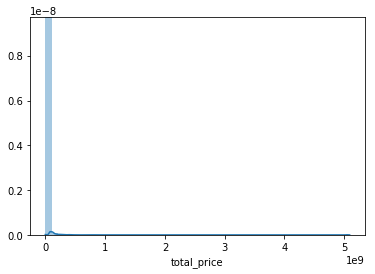

In [12]:
sns.distplot(train_df['total_price'])
# 機率...

In [13]:
import scipy.stats as stats
from scipy import stats
from scipy.stats import norm, skew 

In [14]:
stats.shapiro?
# for naomal test

In [15]:
train_df['total_price'].sample(n=5000, random_state=100).values
# `smaple` means get 5000 results in 60000 results in dataset

array([11815402.03862225,  4721935.3995939 ,  6521089.8559632 , ...,
        4721935.3995939 ,  4722101.71212749,  7493081.26315933])

In [16]:
# p-value <0.01
#test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
#normal = pd.DataFrame(train_df['total_price'])
stats.shapiro(np.log(train_df['total_price'].sample(n=5000, random_state=100).values))
#print(not normal.any())

(0.9875069856643677, 1.2197893695010346e-20)

In [17]:
import scipy.stats as stats

# p-value <0.01
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(train_df[quantitative].sample(n=5000, random_state=100))
normal = normal.apply(test_normality)
print(not normal.any())
# not nomal at all

False


In [18]:
def dist_check(y,kind='log'):
    if kind == 'log':
       y_c = np.log(y)
    else:
       y_c = y 
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    sns.distplot(y_c , fit=norm);
    (mu, sigma) = norm.fit(y_c)
    #print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    plt.legend(['Normal dist. ($\mu:$ {:.2f}, $\sigma:$ {:.2f} )'.format(mu, sigma)],fontsize=14,
            loc='best')
    plt.title('Convert by %s' %kind)
    plt.ylabel('Frequency')
    
    plt.subplot(122)
    #fig = plt.figure(figsize=[8,6])
    res = stats.probplot(y_c, plot=plt)

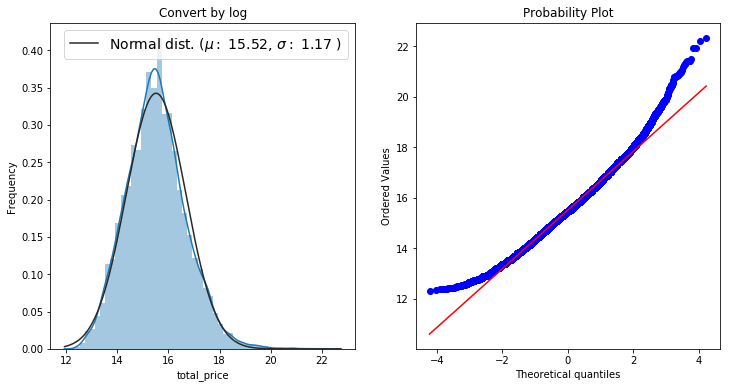

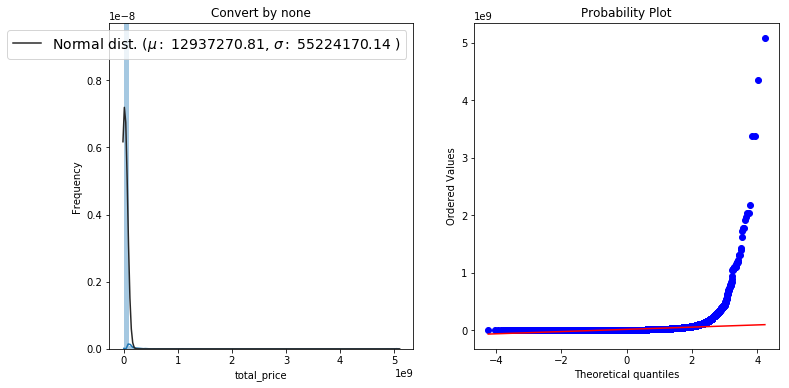

In [19]:
y=(train_df['total_price'])

dist_check(y,kind = 'log')
dist_check(y,kind = 'none')

# Skewness & Kurtisis
1. Skewness > 0, log-tall on the right-side < 0, on the left-side
2. Kurtisis large, sleep in the peak

In [20]:
# too large for data skewness and kurtosis
print("Skewness: %f" % train_df['total_price'].skew()) 
print("Kurtosis: %f" % train_df['total_price'].kurt())

Skewness: 40.183985
Kurtosis: 2592.965135


In [21]:
# try another one in log degree, look ...
print("Skewness: %f" % np.log(train_df['total_price']).skew()) 
print("Kurtosis: %f" % np.log(train_df['total_price']).kurt())

Skewness: 0.375563
Kurtosis: 0.537999


Add a new feature
```
train_df['new_feature'] = ...
```

**Linear dependings** of quantitative feature and log(taget) variable and others

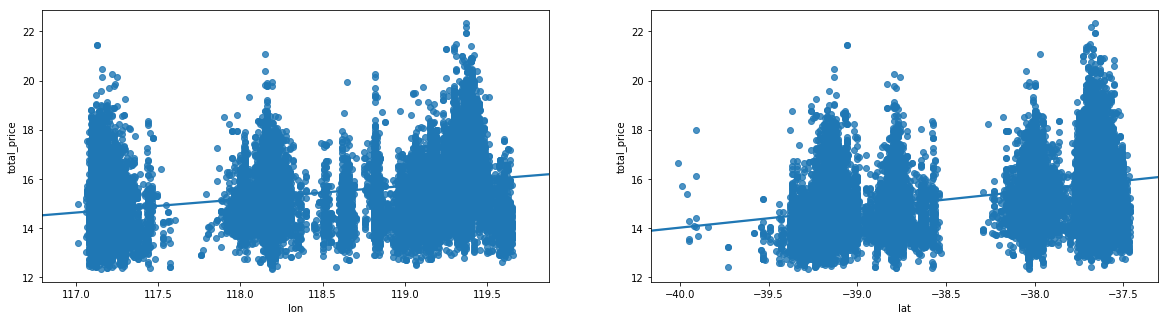

In [22]:
plt.figure(figsize=(20, 5))
log_target=np.log(train_df['total_price'])

for num, var in enumerate(quantitative[-2:]):
    plt.subplot(1, len(quantitative[-2:]), num + 1)
    sns.regplot(x=train_df[var], y = log_target);

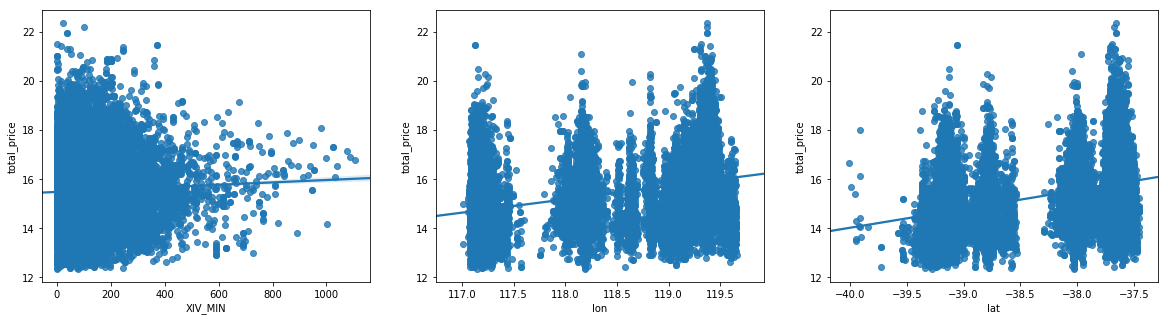

In [23]:
plt.figure(figsize=(20, 5))
log_target=np.log(train_df['total_price'])
n=8
for num, var in enumerate(quantitative[3*(n-1):3*n]):
    plt.subplot(1, len(quantitative[:3]), num + 1)
    sns.regplot(x=train_df[var], y = log_target);

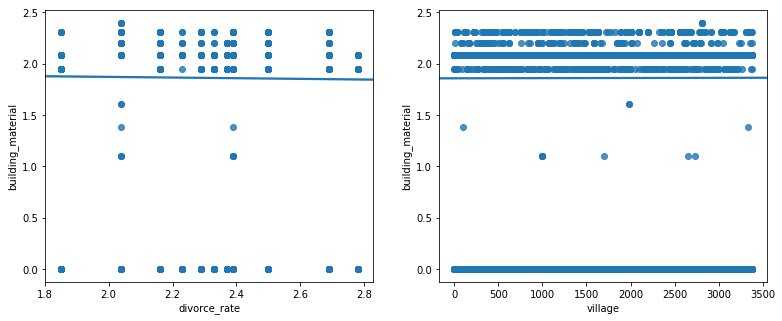

In [35]:
plt.figure(figsize=(20, 5))
log_target=np.log(train_df['building_material'])
#log_target=np.log(train_df['total_price'])
n=7

for num, var in enumerate(qualitative[3*(n-1):3*n]):
    plt.subplot(1, len(qualitative[:3]), num + 1)
    sns.regplot(x=train_df[var], y = log_target);

In [25]:
# only one class in this feature, remove it
#train_df['I_index_5000'].value_counts()
f = train_df.columns.values[1:]
train_df[f[32:62]].nunique()

N_50                13
N_500               15
N_1000              14
N_5000               5
N_10000              3
I_10                 3
I_50                 6
I_index_50           2
I_100                9
I_250               17
I_500               33
I_index_500          2
I_1000              80
I_index_1000         2
I_5000             853
I_index_5000         1
I_10000           1737
I_index_10000        1
I_MIN            45951
II_10                5
II_50               12
II_index_50          2
II_100              21
II_250              58
II_500             114
II_index_500         2
II_1000            288
II_index_1000        2
II_5000           2724
II_index_5000        1
dtype: int64

In [26]:
# for loop when the value becomes 1 or all the same, put the columes into removale array
features = train_df.columns.values[1:]
train_df[features[32:62]].nunique()

N_50                13
N_500               15
N_1000              14
N_5000               5
N_10000              3
I_10                 3
I_50                 6
I_index_50           2
I_100                9
I_250               17
I_500               33
I_index_500          2
I_1000              80
I_index_1000         2
I_5000             853
I_index_5000         1
I_10000           1737
I_index_10000        1
I_MIN            45951
II_10                5
II_50               12
II_index_50          2
II_100              21
II_250              58
II_500             114
II_index_500         2
II_1000            288
II_index_1000        2
II_5000           2724
II_index_5000        1
dtype: int64

In [27]:
train_df[features[62:93]].nunique()

II_10000            6277
II_index_10000         1
II_MIN             45950
III_10                 7
III_50                13
III_index_50           2
III_100               25
III_250               74
III_500              169
III_index_500          2
III_1000             504
III_index_1000         2
III_5000            5463
III_index_5000         1
III_10000          10489
III_index_10000        1
III_MIN            45951
IV_10                  3
IV_50                  9
IV_index_50            2
IV_100                15
IV_250                40
IV_500                83
IV_index_500           2
IV_1000              160
IV_index_1000          2
IV_5000              514
IV_index_5000          2
IV_10000             685
IV_index_10000         1
IV_MIN             45951
dtype: int64

In [28]:
train_df[features[93:124]].nunique()

V_10                  7
V_50                 15
V_index_50            2
V_100                27
V_250                72
V_500               171
V_index_500           2
V_1000              471
V_index_1000          2
V_5000             4137
V_index_5000          1
V_10000            7688
V_index_10000         1
V_MIN             45951
VI_10                 2
VI_50                 3
VI_index_50           2
VI_100                5
VI_250               14
VI_500               31
VI_index_500          2
VI_1000              70
VI_index_1000         2
VI_5000             314
VI_index_5000         1
VI_10000            525
VI_index_10000        1
VI_MIN            45951
VII_10               10
VII_50               34
VII_index_50          2
dtype: int64

In [29]:
train_df[features[124:155]].nunique()

VII_100                76
VII_250               255
VII_500               653
VII_index_500           2
VII_1000             1789
VII_index_1000          2
VII_5000            12518
VII_index_5000          1
VII_10000           18926
VII_index_10000         1
VII_MIN             45950
VIII_10                10
VIII_50                33
VIII_index_50           2
VIII_100               82
VIII_250              206
VIII_500              462
VIII_index_500          2
VIII_1000            1207
VIII_index_1000         2
VIII_5000           10266
VIII_index_5000         1
VIII_10000          17386
VIII_index_10000        1
VIII_MIN            45950
IX_10                   4
IX_50                  13
IX_index_50             2
IX_100                 25
IX_250                 76
IX_500                175
dtype: int64

In [30]:
train_df[features[155:186]].nunique()

IX_index_500          2
IX_1000             465
IX_index_1000         2
IX_5000            3874
IX_index_5000         2
IX_10000           6648
IX_index_10000        1
IX_MIN            45951
X_10                  5
X_50                  8
X_index_50            2
X_100                12
X_250                31
X_500                68
X_index_500           2
X_1000              221
X_index_1000          2
X_5000             2148
X_index_5000          1
X_10000            4514
X_index_10000         1
X_MIN             45951
XI_10                 3
XI_50                 8
XI_index_50           2
XI_100                9
XI_250               22
XI_500               61
XI_index_500          2
XI_1000             160
XI_index_1000         2
dtype: int64

In [31]:
train_df[features[210:227]].nunique()

XIII_500              154
XIII_index_500          2
XIII_1000             190
XIII_index_1000         2
XIII_5000            1275
XIII_index_5000         2
XIII_10000           2697
XIII_index_10000        2
XIII_MIN            45951
XIV_10                  8
XIV_50                 44
XIV_index_50            2
XIV_100               111
XIV_250               335
XIV_500               741
XIV_index_500           2
XIV_1000             1937
dtype: int64

In [61]:
train_df[features[217:248]].nunique()

XIII_MIN           45951
XIV_10                 8
XIV_50                44
XIV_index_50           2
XIV_100              111
XIV_250              335
XIV_500              741
XIV_index_500          2
XIV_1000            1937
XIV_index_1000         2
XIV_5000           12687
XIV_index_5000         1
XIV_10000          22305
XIV_index_10000        1
XIV_MIN            45951
total_price        16555
dtype: int64

In [ ]:
positive_features['...','...']
nagative_features['...','...']

Within the last half part of features, features should be considered in group, for instance, the features about their neighborhood infomation:
      
        'N_50','N_500','N_1000','N_10000' 
Group them together and name it as `N_arr`


In [32]:
removale=['I_index_5000','I_index_10000', 'II_index_5000','II_index_10000','III_index_5000','III_index_10000',
          'IV_index_10000','V_index_5000','V_index_10000','VI_index_5000','VI_index_10000','VII_index_5000',
          'VII_index_10000','VIII_index_5000','VIII_index_10000','IX_index_10000','X_index_5000','X_index_10000',
          'XII_index_5000','XII_index_10000','XIV_index_5000','XIV_index_10000']
N_arr=['N_50','N_500','N_1000','N_5000','N_10000']
I_arr=['I_10','I_50','I_100','I_250','I_500','I_1000','I_5000','I_10000']
I_ind_arr=['I_index_50','I_index_500','I_index_1000']
II_arr=['II_10','II_50','II_100','II_250','II_500','II_1000','II_5000','II_10000']
II_ind_arr=['II_index_50','II_index_500','II_index_1000']
III_arr=['III_10','III_50','III_100','III_250','III_500','III_1000','III_5000','III_10000']
III_ind_arr=['III_index_50','III_index_500','III_index_1000']
IV_arr=['IV_10','IV_50','IV_100','IV_250','IV_500','IV_1000','IV_5000','IV_10000']
IV_ind_arr=['IV_index_50','IV_index_500','IV_index_1000','IV_index_5000']
V_arr=['V_50','V_100','V_250','V_500','V_1000','V_5000','V_10000']
V_ind_arr=['V_index_50','V_index_500','V_index_1000']
VI_arr=['VI_10','VI_50','VI_100','VI_250','VI_500','VI_1000','VI_5000','VI_10000']
VI_ind_arr=['VI_index_50','VI_index_500''VI_index_1000']
VII_arr=['VII_10','VII_50','VII_250','VII_500','VII_1000','VII_5000','VII_10000']
VII_ind_arr=['VII_index_50','VII_index_500','VII_index_1000']
VIII_arr=['VIII_10','VIII_50','VIII_100','VIII_250','VIII_500','VIII_1000','VIII_5000','VIII_10000']
VIII_ind_arr=['VIII_index_50','VIII_index_500','VIII_index_1000']
IX_arr=['IX_10','IX_50','IX_100','IX_250','IX_500','IX_1000','IX_5000','IX_10000']
IX_ind_arr=['IX_index_50','IX_index_10000','IX_index_5000']
X_arr=['X_10','X_50','X_100','X_250','X_500','X_1000','X_5000','X_10000']
X_ind_arr=['X_index_50','X_index_500','X_index_1000']
XI_arr=['XI_10','XI_50','XI_100','XI_250','XI_500','XI_1000','XI_10000']
XI_ind_arr=['XI_index_50','XI_index_500','XI_index_1000','XI_index_5000','XI_index_10000']
XII_arr=['XII_10','XII_50','XII_100','XII_250','XII_500','XII_1000','XII_5000','XII_10000']
XII_ind_arr=['XII_ind_50','XII_ind_500','XII_ind_1000']
XIII_arr=['XIII_10','XIII_50','XIII_100','XIII_250','XIII_500','XIII_1000','XIII_5000','XIII_10000']
XIII_ind_arr=['XIII_index_50','XIII_index_500','XIII_index_1000','XIII_index_5000','XIII_index_10000']
XIV_arr=['XIV_10','XIV_50','XIV_100','XIV_250','XIV_500','XIV_1000','XIV_5000','XIV_10000']
XIV_ind_arr=['XIV_index_50','XIV_index_500','XIV_index_1000']
target=['total_price']


In [ ]:
plt.figure(figsize=(20, 5))
vars=I_ind_arr
for num, var in enumerate(vars):
    plt.subplot(1, len(vars), num + 1)
    sns.regplot(x=train_df[var], y = log_target);

In [ ]:
def spearman(frame, features,target='total_price'):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame[target], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = quantitative 

In [ ]:
spearman(train_df, features)

In [ ]:
target=['total_price']
plt.figure(1)
corr = train_df[quantitative+target].corr()
sns.heatmap(corr)
plt.figure(2)
corr = train_df[qual_encoded+target].corr()
sns.heatmap(corr)
plt.figure(3)
corr = pd.DataFrame(np.zeros([len(quantitative)+1, len(qual_encoded)+1]), index=quantitative+target, columns=qual_encoded+['SalePrice'])
for q1 in quantitative+target:
    for q2 in qual_encoded+target:
        corr.loc[q1, q2] = train_df[q1].corr(train_df[q2])
sns.heatmap(corr)

In [ ]:
train_df[set(XII_ind_arr).union(target)].corr()